In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


## MLP网络结构

In [7]:
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, output_dim, bias=True)
        )

        torch.nn.init.xavier_uniform_(self.layer1[0].weight)
        torch.nn.init.zeros_(self.layer1[0].bias)

        torch.nn.init.xavier_uniform_(self.layer1[0].weight)
        torch.nn.init.zeros_(self.layer1[0].bias)

    def forward(self, x):
        x = torch.tensor(x,dtype=torch.float32)

        x = self.layer1(x)
        x = self.layer2(x)
        return x


## 导入数据

In [8]:
# 导入数据
df = pd.read_csv("BreastCancer/wdbc.data",header=None)
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
y = np.where(y == 'B', 0, 1)
y = np.squeeze(y)

# 分割测试/训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 数据归一化
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
train_dst = TensorDataset(X_train, y_train) 
test_dst = TensorDataset(X_test, y_test)
print('X_train:',X_train.shape,'  X_test:',X_test.shape)
print('y_train:',y_train.shape,'  y_test:',y_test.shape)

df.head()

# 数据维度：30


X_train: torch.Size([455, 30])   X_test: torch.Size([114, 30])
y_train: torch.Size([455])   y_test: torch.Size([114])


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 开始训练

TODO：新增公式

In [9]:
# fixed parameters
input_dim = 30 # e.g. data input dimension(feature nums)
output_dim = 2 # e.g. a classification task of 2 class
class_count = 2

''' 
Training Hyperparameters (可调参)
TODO:调参技巧
'''
max_epoch = 50
hidden_dim = 128 # you can define your own net structure
learning_rate = 0.01
batch_size = 64

# prepare dataloader
train_loader = DataLoader(train_dst, batch_size=batch_size) # , shuffle=True
test_loader = DataLoader(test_dst, batch_size=batch_size) # , shuffle=True

# prepare model / optimizer / loss function
model = MLP2(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate )


epoch_list = []
loss_list = []
acc_list = []


for epoch in range(max_epoch):
    model.train()
    for batch_inputs, batch_labels in train_loader:
        # Transform label to one_hot
        batch_one_hot_label = torch.eye(class_count)[batch_labels.type(torch.long),:]
        # print('batch_one_hot_label:',batch_one_hot_label.shape)

        # forward
        outputs = model(batch_inputs)

        # Compute loss
        optimizer.zero_grad()
        loss = loss_fn(outputs, batch_one_hot_label)
        
        # backward
        loss.backward()  

        # updata weights
        optimizer.step()
    
    # validation
    correct_number = 0
    total_number = 0
    for batch_inputs, batch_labels in test_loader:
        # forward
        outputs = model(batch_inputs) # bs, 2

        # calculate prediction acuuracy
        pred_label = torch.argmax(outputs,dim=1)
        correct_number += torch.sum(pred_label == batch_labels)
        total_number+= batch_labels.shape[0]

    test_acc = correct_number/total_number

    epoch_list.append(epoch)
    loss_list.append(loss.item())
    acc_list.append(test_acc)

    if epoch%5 == 0:
        print(f'Epoch {epoch}: loss={loss.item()} test_acc={test_acc}')


Epoch 0: loss=0.3214237689971924 test_acc=0.8245614171028137
Epoch 5: loss=0.0960850864648819 test_acc=0.9385964870452881
Epoch 10: loss=0.03993368521332741 test_acc=0.9298245906829834
Epoch 15: loss=0.022299766540527344 test_acc=0.9122806787490845
Epoch 20: loss=0.01244167797267437 test_acc=0.8859649300575256
Epoch 25: loss=0.007988570258021355 test_acc=0.8771929740905762
Epoch 30: loss=0.005768530536442995 test_acc=0.859649121761322
Epoch 35: loss=0.004479563795030117 test_acc=0.8421052694320679
Epoch 40: loss=0.003686044830828905 test_acc=0.8333333134651184
Epoch 45: loss=0.0028041282203048468 test_acc=0.8157894611358643


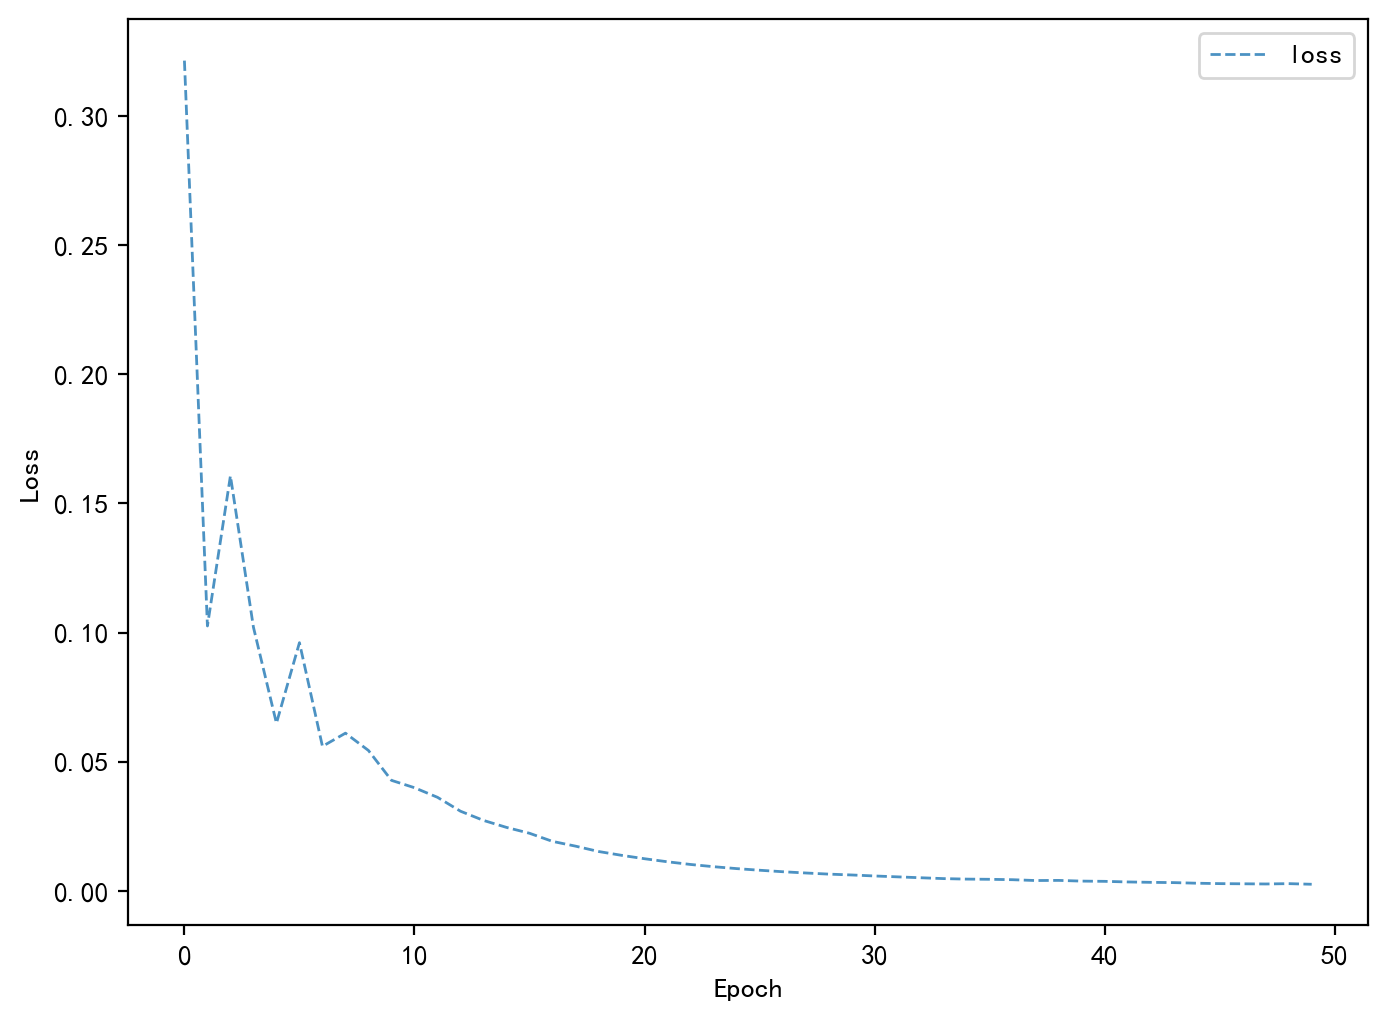

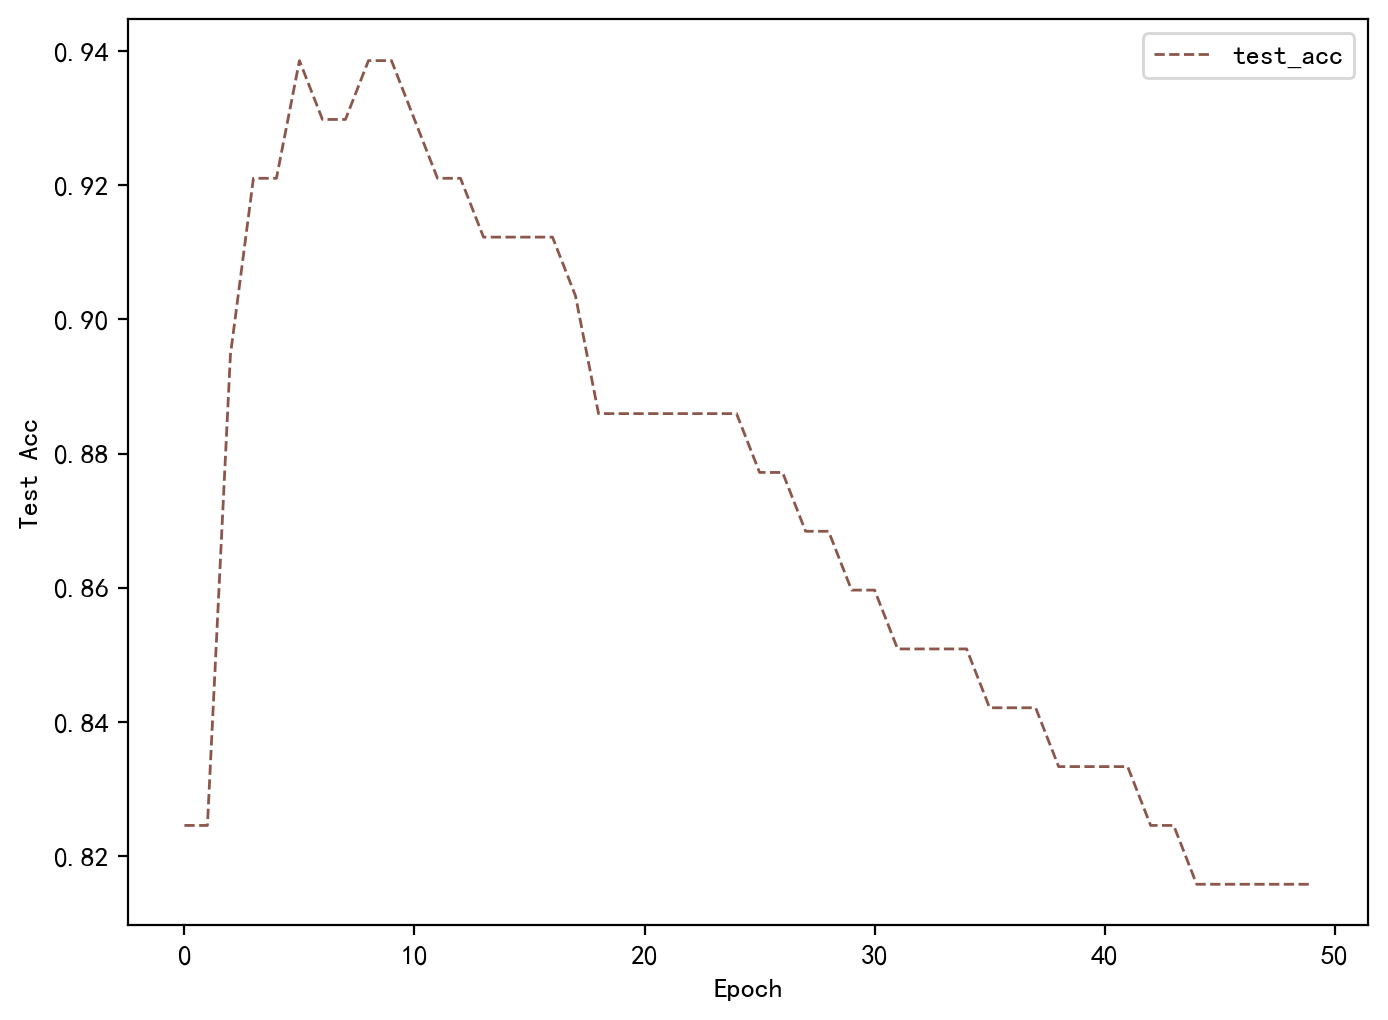

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig=plt.figure(figsize=(8,6),dpi=200)
plt.plot(epoch_list, loss_list, '--', alpha=0.8, linewidth=1, color = color_list[0],label='loss')
plt.legend()  #显示上面的label
plt.xlabel('Epoch') #x_label
plt.ylabel('Loss')#y_label
# plt.savefig('SH/'+date_str+'_load_plot.png')
plt.show()

fig=plt.figure(figsize=(8,6),dpi=200)
plt.plot(epoch_list, acc_list, '--',alpha=1, linewidth=1, color = color_list[5],label='test_acc')
plt.legend()  #显示上面的label
plt.xlabel('Epoch') #x_label
plt.ylabel('Test Acc')#y_label
# plt.savefig('SH/'+date_str+'_load_plot.png')
plt.show()


